In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout
import os, io,zipfile
from PIL import Image
import tqdm
import cv2
from pathlib import Path

In [3]:
# load data - data has training (tumor,no-tumor) and test (tumor,no-tumor) datasets

zip_file_path=("/content/MRIBrainTumor.zip")
extracted_dir=("/content/extracted_data")
!mkdir -p $extracted_dir
with zipfile.ZipFile(zip_file_path,'r') as zip_ref:
  zip_ref.extractall(extracted_dir)
!ls $extracted_dir

Testing  Training


In [87]:
from pathlib import Path
from keras.preprocessing import image
import numpy as np

# path_to_no_tumor_directory and "path_to_pituitary_tumor_directory"
no_tumor_path = Path("/content/extracted_data/Training/no_tumor")
pituitary_tumor_path = Path("/content/extracted_data/Training/pituitary_tumor")

images = []  # List for images
labels = []  # Each time load the image and put in image array, add labels 1 tumor / 0 no-tumor to the labels array

for img_path in no_tumor_path.glob("*jpg"):
    img = image.load_img(img_path, target_size=(224, 224),color_mode='grayscale')  # Load img from disk - load img files' contents to memory
    img_array = image.img_to_array(img)  # Convert img to list of images

    images.append(img_array)  # Add img to list of images
    labels.append(0)  # For each not-tumor: value is 0

for img_path in pituitary_tumor_path.glob("*jpg"):
    img = image.load_img(img_path, target_size=(224, 224),color_mode='grayscale')  # Load img from disk - load img files' contents to memory
    img_array = image.img_to_array(img)  # Convert img to list of images
    images.append(img_array)  # Add img to list of images
    labels.append(1)  # For each tumor: value is 1

# create a single numpy array (not a python list) with all the images we loaded
x_train=np.array(images)
#convert labels to a numpy array
y_train=np.array(labels)


In [88]:
np.unique(y_train)  # 2 classes 0 and 1

array([0, 1])

In [89]:
x_train.shape  #(1222, 224, 224, 1)
#y_train.shape #(1222,)

(1222, 224, 224, 1)

In [67]:
pd.Series(y_train).value_counts()

1    651
0    326
dtype: int64

In [90]:
xtrain, xtest, ytrain, ytest = train_test_split(x_train, y_train, random_state=10, test_size=0.2)


In [73]:
xtest.min(), xtest.max(),

(0.0, 255.0)

In [91]:
# feature scaling  between 0 to 1
xtrain=xtrain.astype('float32')
xtest=xtest.astype("float32")
xtrain/=255
xtest/=255
print(xtrain.min(), xtrain.max())
print(xtest.min(), xtest.max())


0.0 1.0
0.0 1.0


In [92]:
# one-hot encode the labels #no-tumor 0 and tumor 1 -> convert label index to categorical encoding
# convert class vectors to binary class metrices - array with an elemnt set to 1 and the rest 0

from tensorflow.keras.utils import to_categorical
ytrain=to_categorical(ytrain, 2) # number of classes is 2
ytest=to_categorical(ytest, 2)
ytest


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.

In [94]:
# Train Model Convolutional Neural Network # VGG Shorten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten

# maxpool: scale down convolution laers - keep largest values # dropout usually after maxpool # extra pixels left over an edge (ima size is not exactly /3) : add padding to img 0 3xtrat 0 added to edge : same padding
model=Sequential()

model.add(Conv2D(32,(3,3),padding='same', activation='relu',input_shape=(224,224,1)))  # image 2D # each filter is capable of detecting 1 pattern - sinze of window 3x3 : use when creating tiles from each image -> org to 3x3 tiles
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) # % of nn to cut (bet 25 to 50)

model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) # % of nn to cut (bet 25 to 50

# transition from convolution layer to dense layer : no work with D data -> flatten layer
model.add(Flatten())  # to output
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))  # 50 : workharder to get the las answer correct

model. add(Dense(2, activation='sigmoid')) # if was mroe classes : softmax

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 conv2d_25 (Conv2D)          (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_26 (Conv2D)          (None, 111, 111, 64)      18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 109, 109, 64)      36928     
                                                      

In [95]:
# train
history=model.fit(xtrain,ytrain,epochs=5,shuffle=True,validation_split=0.1)


Epoch 1/5
28/28 [==============================] - 10s 274ms/step - loss: 0.6724 - accuracy: 0.7133 - val_loss: 0.3083 - val_accuracy: 0.8776
Epoch 2/5
28/28 [==============================] - 4s 157ms/step - loss: 0.2451 - accuracy: 0.9101 - val_loss: 0.0947 - val_accuracy: 0.9490
Epoch 3/5
28/28 [==============================] - 4s 157ms/step - loss: 0.0987 - accuracy: 0.9716 - val_loss: 0.0593 - val_accuracy: 0.9796
Epoch 4/5
28/28 [==============================] - 4s 156ms/step - loss: 0.0427 - accuracy: 0.9886 - val_loss: 0.0451 - val_accuracy: 0.9898
Epoch 5/5
28/28 [==============================] - 4s 157ms/step - loss: 0.0428 - accuracy: 0.9841 - val_loss: 0.2091 - val_accuracy: 0.9388


In [96]:
# batch_size=32,epochs=1,shuffle=True
# batch size: how many at once fit in nn during training -32-128 images
# epochs how mant times trainig data during the process
# validation_data=(x_test,y_test), validate our training - this is data that model will never see dring training and test the acc of the training data
# randomize the order of the training data : shuffle True

In [97]:
model_structure=model.to_json() # save NN -write json to text
f=Path("model_structure.json") # path object
f.write_text(model_structure)

#save weights
model.save_weights('braintumor.weights.h5')

1/1 [==============================] - 0s 18ms/step


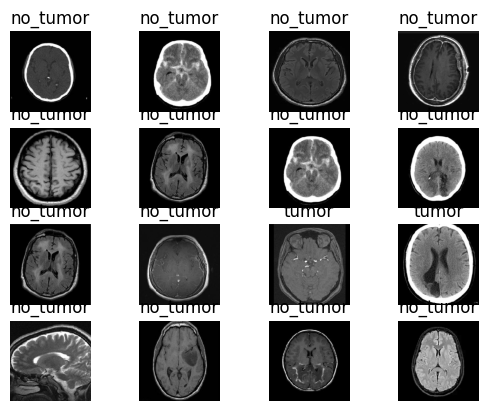

In [98]:
from pathlib import Path
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Test Model
class_labels = ["no_tumor", "tumor"]

# Path to directories containing images
p=Path("/content/extracted_data/Testing")
no_tumor_path = Path("/content/extracted_data/Testing/no_tumor")
pituitary_tumor_path = Path("/content/extracted_data/Testing/pituitary_tumor")

# Plot images
c = 1
for img_path in no_tumor_path.glob("*jpg"):
    if c > 16:  # Break out of loop if more than 16 images are plotted
        break
    plt.subplot(4, 4, c)
    img = image.load_img(img_path, target_size=(224, 224), color_mode='grayscale')
    img_array = image.img_to_array(img) # Convert image to array
    img_array = img_array.reshape(1, 224,224,1) / 255 # reshape to 4D and perform feature scaling
    p = model.predict(img_array)
    plt.title(class_labels[np.argmax(p)])  # Use argmax to get the predicted class index
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c += 1
plt.show()


1/1 [==============================] - 0s 17ms/step


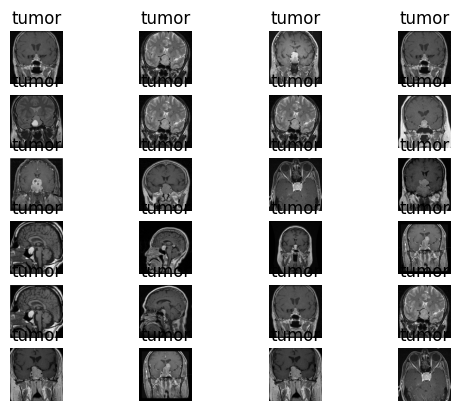

In [100]:
# Plot images
c = 1
for img_path in pituitary_tumor_path.glob("*jpg"):
    if c > 24:  # Break out of loop if more than 16 images are plotted
        break
    plt.subplot(6, 4, c)
    img = image.load_img(img_path, target_size=(224, 224), color_mode='grayscale')
    img_array = image.img_to_array(img)  # Convert image to array and scale
    img_array = img_array.reshape(1, 224,224,1) /255 # Reshape to have correct dimensions
    p = model.predict(img_array)
    plt.title(class_labels[np.argmax(p)])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c += 1
plt.show()  # some are misclassified
